In [ ]:
!apt-get update -qq
!apt-get install -y fonts-dejavu-core > /dev/null
!ls /usr/share/fonts/truetype/dejavu

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
DejaVuSans-Bold.ttf	 DejaVuSansMono.ttf  DejaVuSerif-Bold.ttf
DejaVuSansMono-Bold.ttf  DejaVuSans.ttf      DejaVuSerif.ttf


In [ ]:
!ls

sample_data


In [ ]:
import time
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt

# --- 1. Load model & weights ---
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)
model.eval()

# Class name mapping (for COCO)
categories = weights.meta["categories"]

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 159MB/s]


In [ ]:
def mask_rcnn_inference(image_path):
  # --- 2. Load image ---
  image = Image.open(image_path).convert("RGB")
  input_tensor = F.to_tensor(image)  # [3, H, W] in [0,1]

  # Batch
  input_batch = [input_tensor]

  # --- 3. Run inference ---
  with torch.no_grad():
      start_time = time.time()
      predictions = model(input_batch)
      print(f"Inferernce time (CPU)= {round(time.time() - start_time, 3)} seconds")

  # --- 4. Process predictions for first image ---
  if predictions:
      pred = predictions[0]
      boxes = pred["boxes"]
      labels = pred["labels"]
      scores = pred["scores"]
      masks = pred["masks"]

      # Filter by confidence
      score_threshold = 0.5
      keep = scores >= score_threshold
      boxes = boxes[keep]
      labels = labels[keep]
      scores = scores[keep]
      masks = masks[keep]

      print(f"Detected {len(boxes)} objects with score >= {score_threshold}.")

      if len(boxes) == 0:
          print("No objects above threshold; just showing original image.")
          fig, ax = plt.subplots(1, 1, figsize=(8, 8))
          ax.imshow(image)
          ax.set_title("Original image")
          ax.axis("off")
          plt.show()
      else:
          # --- 5. Prepare image for drawing ---
          img_uint8 = (input_tensor * 255).to(torch.uint8)  # [3, H, W]

          # --- 6. Binary masks ---
          binary_masks = (masks.squeeze(1) > 0.5)  # [N, H, W] bool

          # --- 7. Labels as text (bigger & clearer) ---
          label_strings = []
          for label, score in zip(labels, scores):
              class_name = categories[label]
              label_strings.append(f"{class_name}: {score:.2f}")

          # --- 8. Draw segmentation masks with stronger overlay ---
          # alpha closer to 1.0 = more solid masks (clearer segmentation)
          img_with_masks = draw_segmentation_masks(
              img_uint8,
              binary_masks,
              alpha=0.7  # was 0.5; increase for clearer masks
          )

          # --- 9. Draw bounding boxes + bigger text labels ---
          img_annotated = draw_bounding_boxes(
              img_with_masks,
              boxes,
              labels=label_strings,
              width=3,        # thicker box
              font="/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
              font_size=35    # bigger text
          )

          # To HWC for matplotlib
          img_annotated_np = img_annotated.permute(1, 2, 0).cpu().numpy()

          # --- 10. Plot original vs annotated ---
          fig, axes = plt.subplots(1, 2, figsize=(18, 9))

          # Original
          axes[0].imshow(image)
          axes[0].set_title("Original image", fontsize=16)
          axes[0].axis("off")

          # Annotated
          axes[1].imshow(img_annotated_np)
          axes[1].set_title("Mask R-CNN: segmentation + boxes + labels", fontsize=16)
          axes[1].axis("off")

          plt.tight_layout()
          plt.show()

Inferernce time (CPU)= 7.161 seconds
Detected 1 objects with score >= 0.5.


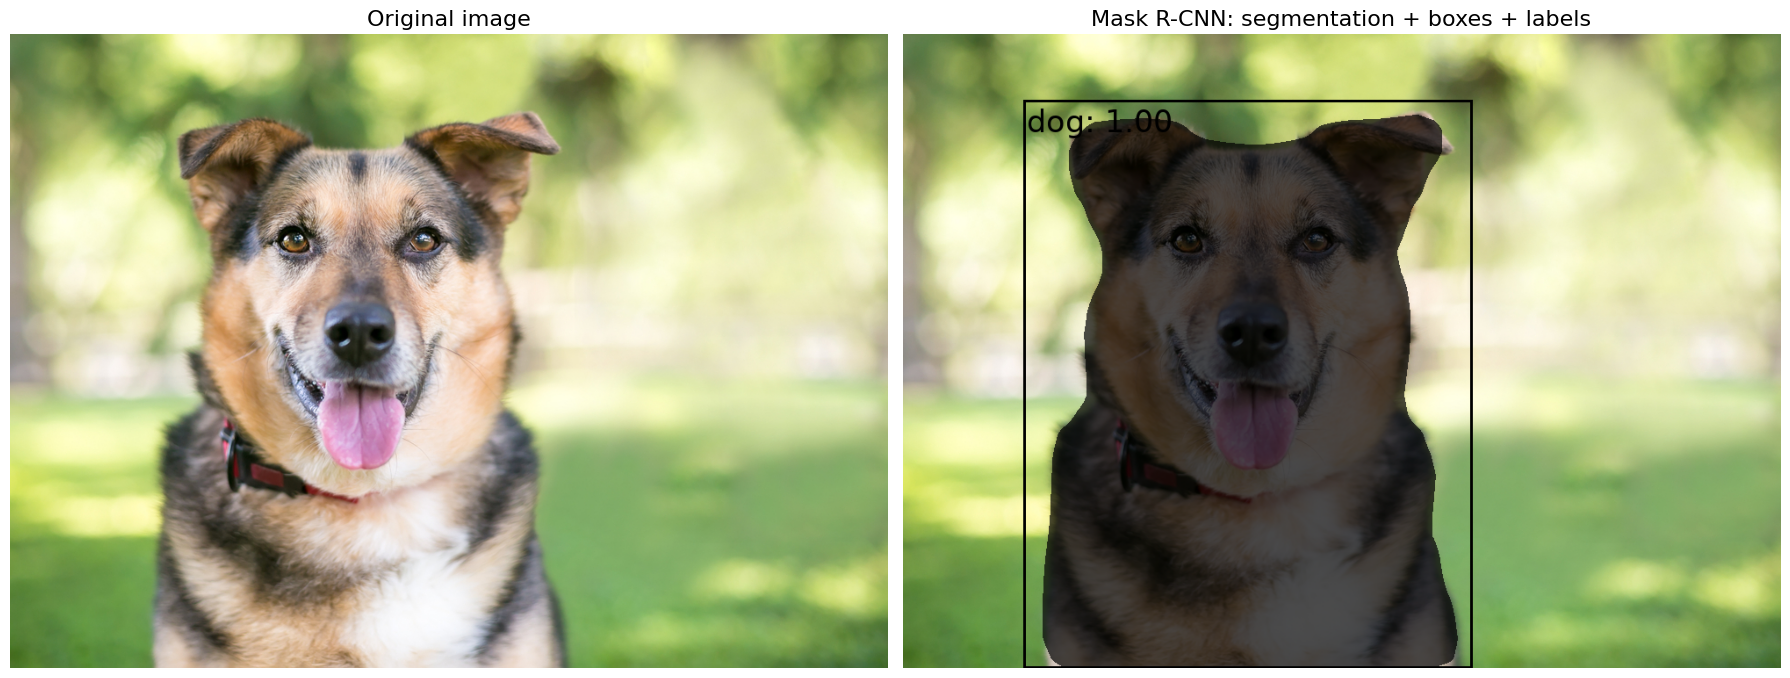

In [ ]:
mask_rcnn_inference('dog_image.jpg')

Inferernce time (CPU)= 8.286 seconds
Detected 2 objects with score >= 0.5.


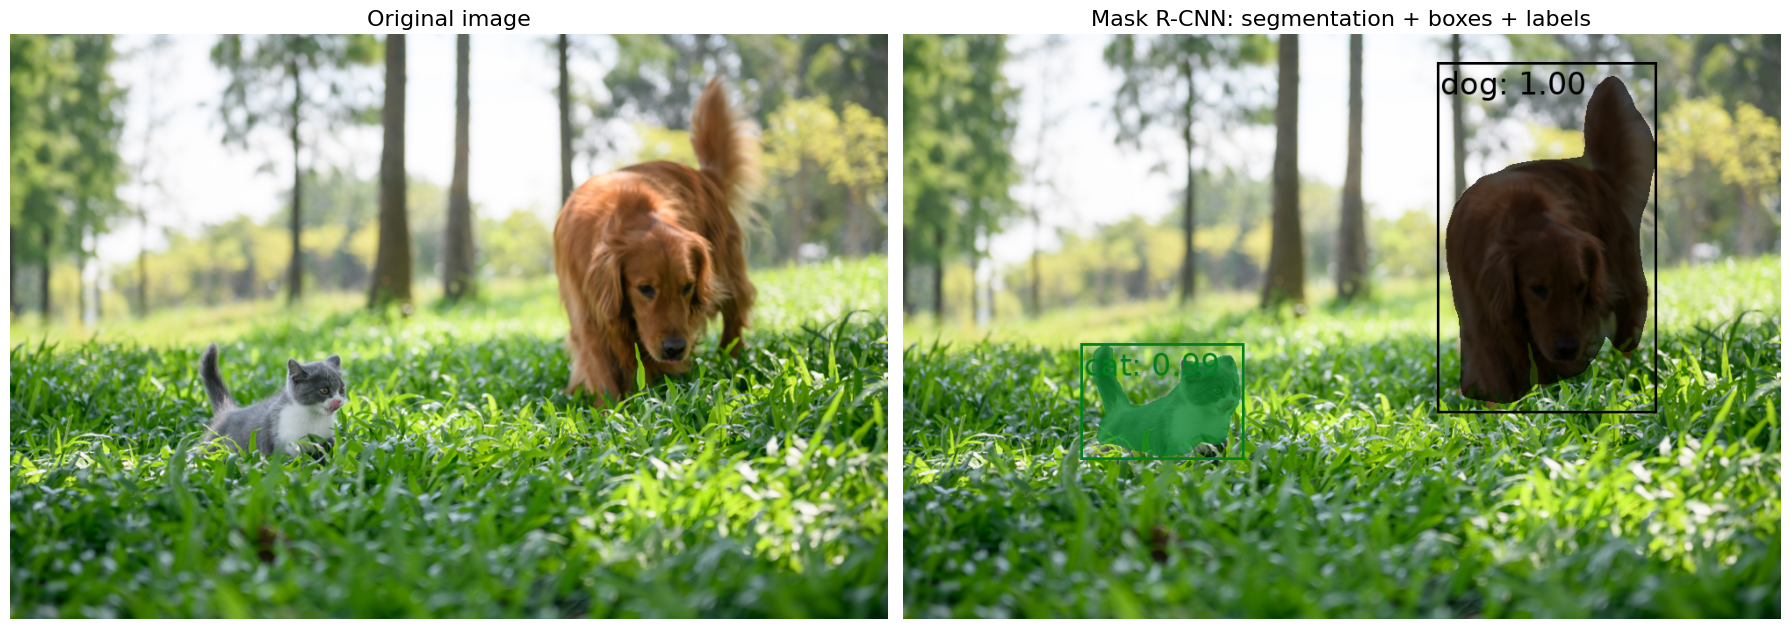

In [ ]:
mask_rcnn_inference('dog_and_cat_image.jpg')

Inferernce time (CPU)= 8.071 seconds
Detected 3 objects with score >= 0.5.


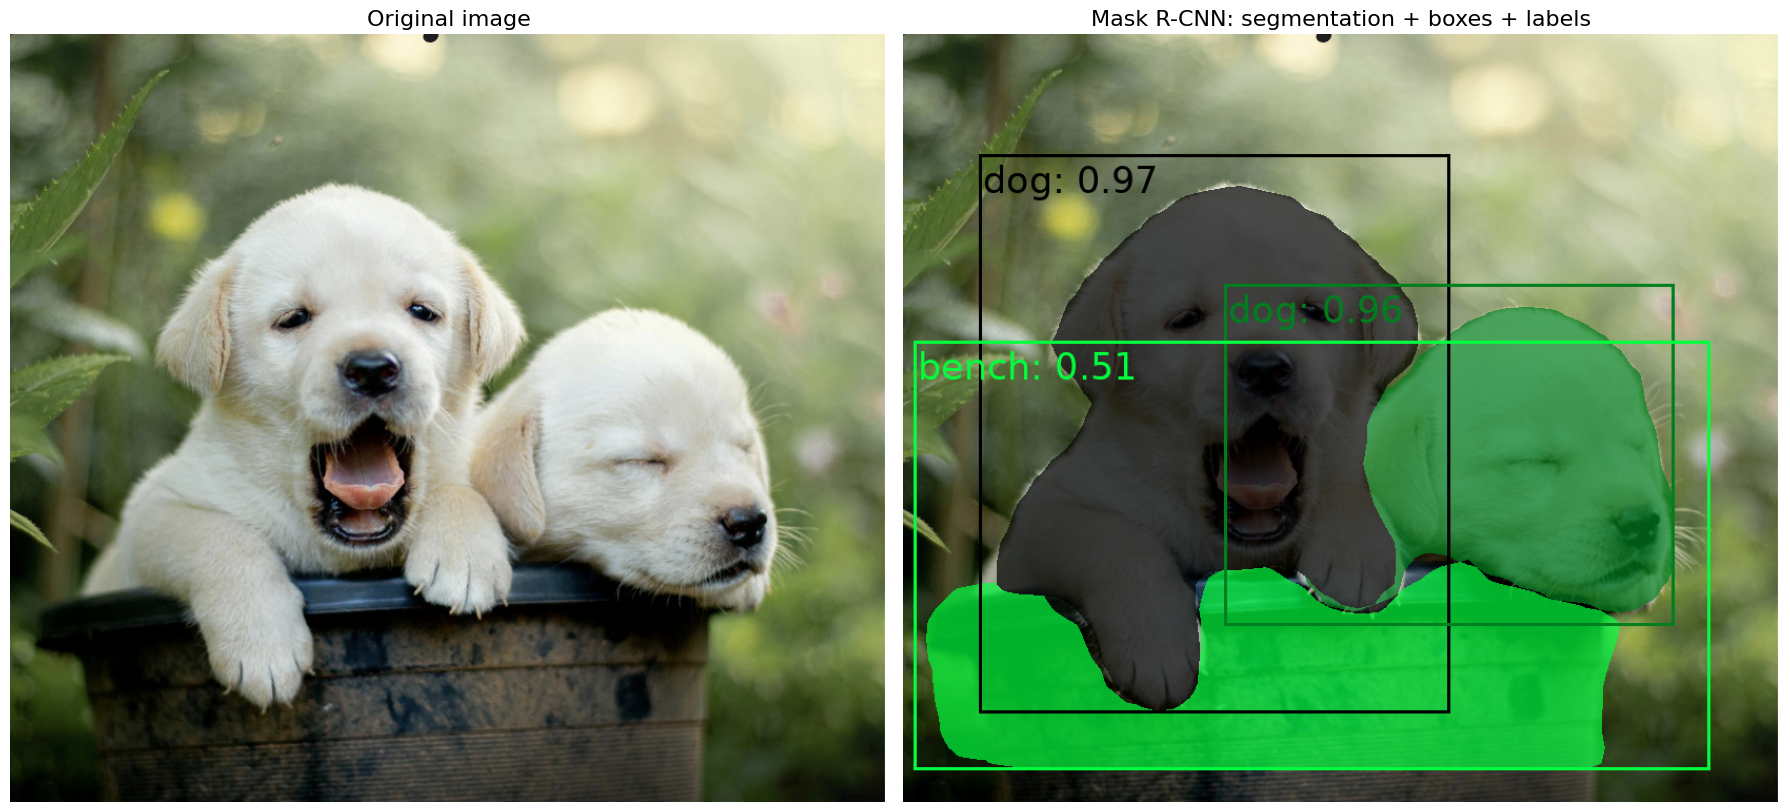

In [ ]:
mask_rcnn_inference('dogs_in_pot.png')

Inferernce time (CPU)= 9.734 seconds
Detected 27 objects with score >= 0.5.


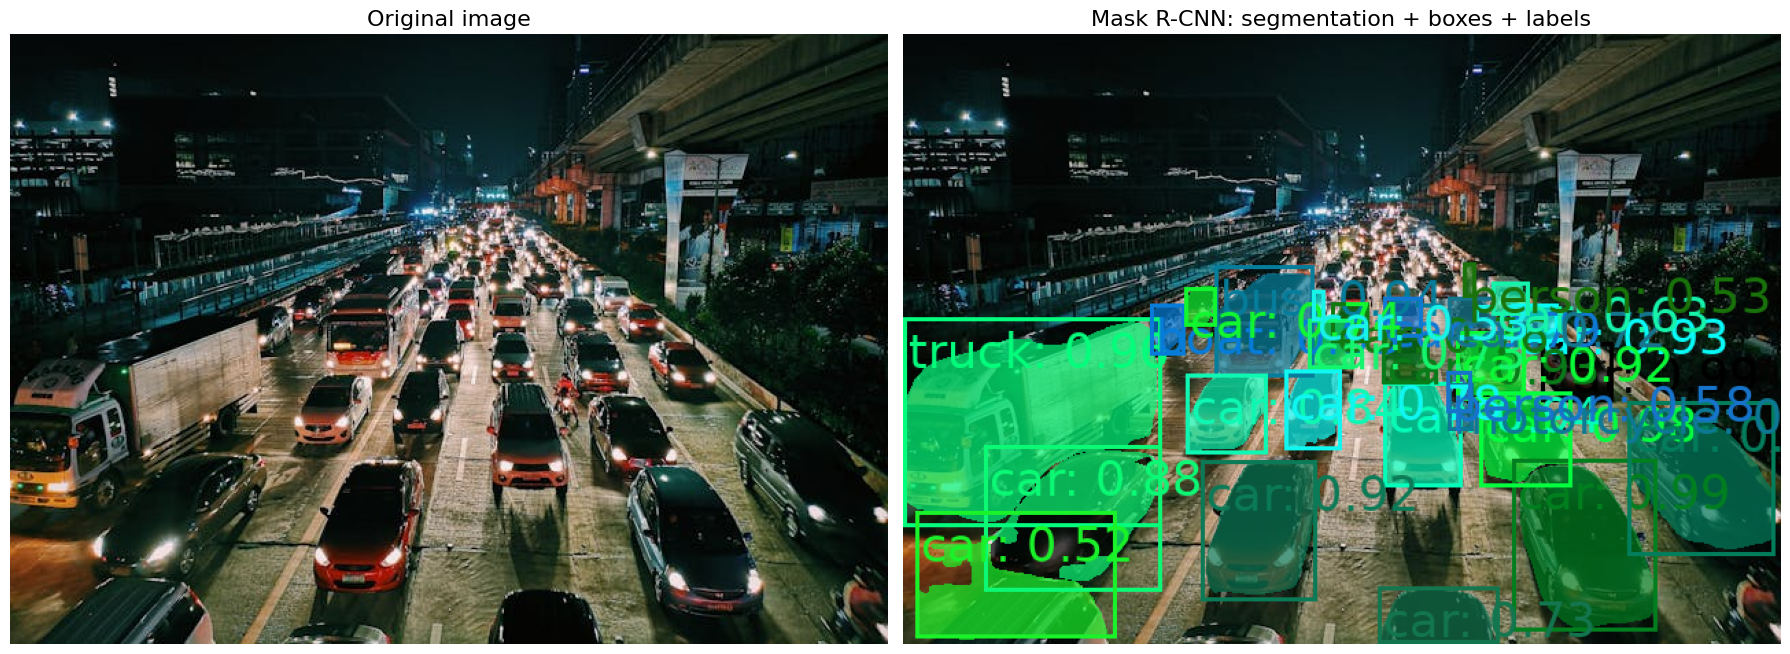

In [ ]:
mask_rcnn_inference('traffic_image.jpg')